**Цель:** по имеющимся параметрам бриллианта определеить его цену.

**Задачи:** 
1. Проанализировать исходные данные и выполнить их предобработку
2. Выбрать оптимальный алгоритм машинного обучения
3. Подбор гиперпараметров
4. Оценка итоговой модели

# Предварительный анализ данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import seaborn as sns

/kaggle/input/diamonds-prices/Diamonds Prices2022.csv


In [2]:
# Стандартные импорты plotly
#import plotly.plotly as py
#import plotly.graph_obs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
# Устанавливаем глобальную тему
#cf.set_config_file(world_readable=True, theme='pearl', offline=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [3]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import IsolationForest

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

## Общая информация о данных

Загрузим исходный датасет:

In [5]:
df = pd.read_csv('/kaggle/input/diamonds-prices/Diamonds Prices2022.csv')

In [6]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Изучим общую информацию о датасете.

In [7]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


В исходном датасете содержится 10 столбцов.
Для дальнейшей работы с переменными cut, color, clarity будет необходимо выполнить их преобразование в категориальные переменные.

Проверим данные на наличие дубликатов и пропусков.

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().mean()

Unnamed: 0    0.0
carat         0.0
cut           0.0
color         0.0
clarity       0.0
depth         0.0
table         0.0
price         0.0
x             0.0
y             0.0
z             0.0
dtype: float64

В датасете нет пропусков и дубликатов, перейдем к кодированию категориальных переменных.

Построим распределение переменной carat.

In [11]:
df['carat'].iplot(kind='hist', xTitle='claps',
                  yTitle='count', title='Claps Distribution')

Создадим копию полученного датасета, поскольку в данной работе будет рассмотрено два способа удаления выбросов - вручную и с помощью уже готовых алгоритмов.

In [12]:
df_auto = df.copy()

Построим распределения переменных в датасете.

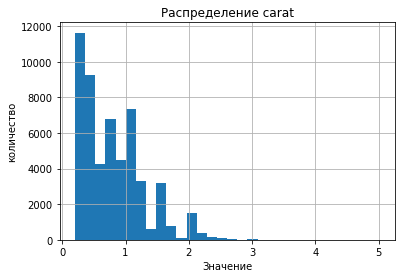

In [13]:
df.carat.hist(bins = 30).set(title = "Распределение carat", xlabel = 'Значение', 
                            ylabel = 'количество');

По графику видим, что значения больше 3 встречаются крайне редко. Наибольшее количество значений встречается в промежутке от 0 до 1. Также  стоит отметить, что есть всплески при значения 1 и 2.График близок к экпоненциальному распределению.

In [14]:
df = df.loc[df.carat < 3]

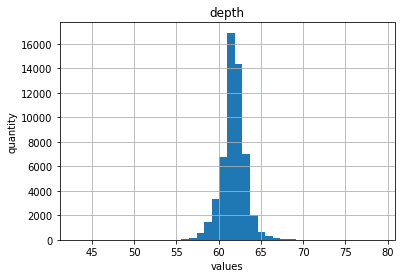

In [15]:
df.depth.hist(bins = 40).set(title = "depth", xlabel = 'values', 
                            ylabel = 'quantity');

Данная переменная имеет распределение, близкое к нормальному. Наибольшая часть значений находится в диапазоне о 59 до 60, наиболее часто встречаются значения 61 и 62. Значения меньше 55 и больше 70 встречаются крайне редко или отсутствуют.

In [16]:
df = df.query("depth > 55 & depth <70")

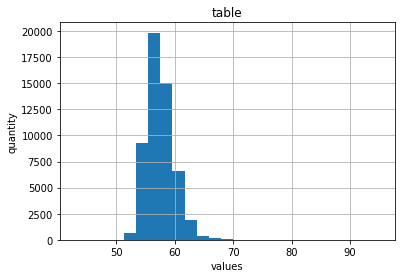

In [17]:
df.table.hist(bins = 25).set(title = "table", xlabel = 'values', 
                            ylabel = 'quantity');

Диапазон значений сосредоточен в промежутке от 50 до 70, наиболее распространенные значения 58 и 59.

In [18]:
df.query("table > 50 & table <70").shape

(53835, 11)

In [19]:
df = df.query("table > 50 & table <70")

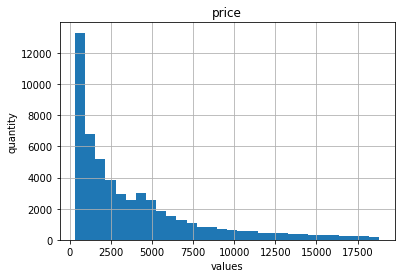

In [20]:
df.price.hist(bins = 30).set(title = "price", xlabel = 'values', 
                            ylabel = 'quantity');

Цена распределена по экспоненте. В рассматриваемом датасете наиболее часто встречаются низкие цены, дорогие бриллианты встречаются значительно реже.

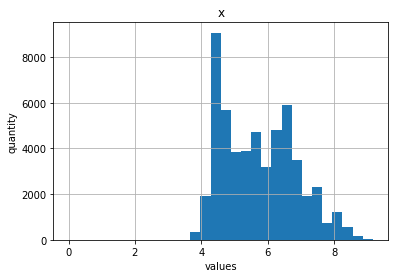

In [21]:
df.x.hist(bins = 30).set(title = "x", xlabel = 'values', 
                            ylabel = 'quantity');

Значения данного признака сосредоточены в промежутке от 4 до 8.

In [22]:
df.query("x > 3.7 & x <9").shape

(53820, 11)

In [23]:
df = df.query("x > 3.7 & x <9")

[Text(0.5, 1.0, 'Y')]

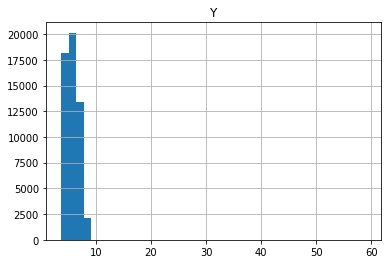

In [24]:
df.y.hist(bins = 40).set(title = "Y")

[Text(0.5, 1.0, 'z')]

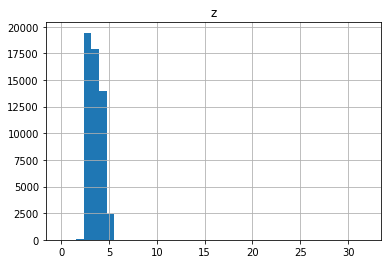

In [25]:
df.z.hist(bins = 40).set(title = "z")

Выполним удаление выбросов с помощью алгоритма IsolationForest

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53820 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53820 non-null  int64  
 1   carat       53820 non-null  float64
 2   cut         53820 non-null  object 
 3   color       53820 non-null  object 
 4   clarity     53820 non-null  object 
 5   depth       53820 non-null  float64
 6   table       53820 non-null  float64
 7   price       53820 non-null  int64  
 8   x           53820 non-null  float64
 9   y           53820 non-null  float64
 10  z           53820 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.9+ MB


In [27]:
df = df.drop(columns = ['Unnamed: 0'])

In [28]:
df_auto = df_auto.drop(columns = ['Unnamed: 0'])

In [29]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


([<matplotlib.patches.Wedge at 0x7f1a0c474d90>,
 [Text(1.0955988161522947, 0.09830174996250349, 'Fair'),
  Text(0.9832935062859626, 0.49308607818093786, 'Good'),
  Text(-0.46581099684476257, 0.996503946413906, 'Ideal'),
  Text(-0.6595838221912188, -0.8803119796433665, 'Premium'),
  Text(0.8378004029206639, -0.7128046610860322, 'Very Good')])

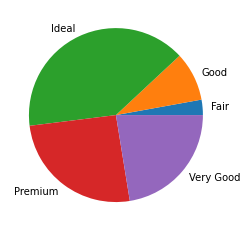

In [30]:
group_pie = df.groupby(['cut']).count()

plt.pie(group_pie.price, labels = group_pie.index)

([<matplotlib.patches.Wedge at 0x7f1a0c468550>,
 [Text(1.0951680124895684, 0.10299040935761386, 'Fair'),
  Text(0.9791003399499252, 0.5013606728792568, 'Good'),
  Text(-0.4718021730824082, 0.9936813923359528, 'Ideal'),
  Text(-0.6568288740189532, -0.8823694409117954, 'Premium'),
  Text(0.8386962844165468, -0.7117503372010997, 'Very Good')])

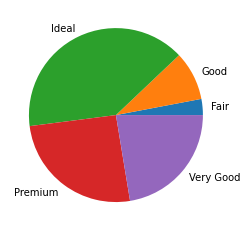

In [31]:
group_pie_auto = df_auto.groupby(['cut']).count()

plt.pie(group_pie_auto.price, labels = group_pie_auto.index)

([<matplotlib.patches.Wedge at 0x7f1a0c72ca10>,
 [Text(1.0154781305533207, 0.42285241676964913, 'D'),
  Text(0.23035061503959114, 1.0756108004993639, 'E'),
  Text(-0.872147270774272, 0.6703425527899813, 'F'),
  Text(-0.9330859450315055, -0.5825380838920855, 'G'),
  Text(0.14102991660358746, -1.0909218865816128, 'H'),
  Text(0.8804339455486082, -0.6594210093147704, 'I'),
  Text(1.0853236454962043, -0.1790882032039789, 'J')])

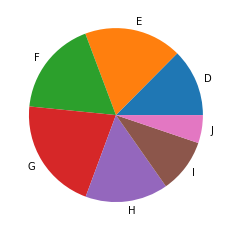

In [32]:
group_pie = df_auto.groupby(['color']).count()

plt.pie(group_pie.price, labels = group_pie.index)

([<matplotlib.patches.Wedge at 0x7f1a0c7d7590>,
 [Text(1.0989758554585989, 0.04745597032029614, 'I1'),
  Text(1.0800884871255756, 0.20834793010439454, 'IF'),
  Text(0.541768580111879, 0.957333173771576, 'SI1'),
  Text(-0.7747651468925323, 0.7808578405578016, 'SI2'),
  Text(-1.073003116674241, -0.24220716671346754, 'VS1'),
  Text(-0.1741245293795405, -1.0861310456240323, 'VS2'),
  Text(0.7640519960098009, -0.7913435078355286, 'VVS1'),
  Text(1.0524697573016386, -0.31985529535311785, 'VVS2')])

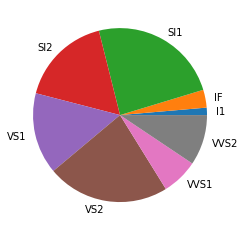

In [33]:
group_pie = df_auto.groupby(['clarity']).count()

plt.pie(group_pie.price, labels = group_pie.index)

<AxesSubplot:>

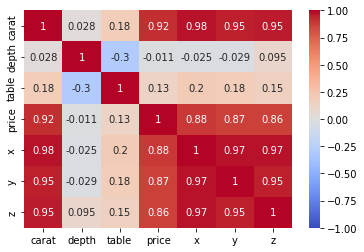

In [34]:
sns.heatmap(df_auto.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

удалим х, у, z

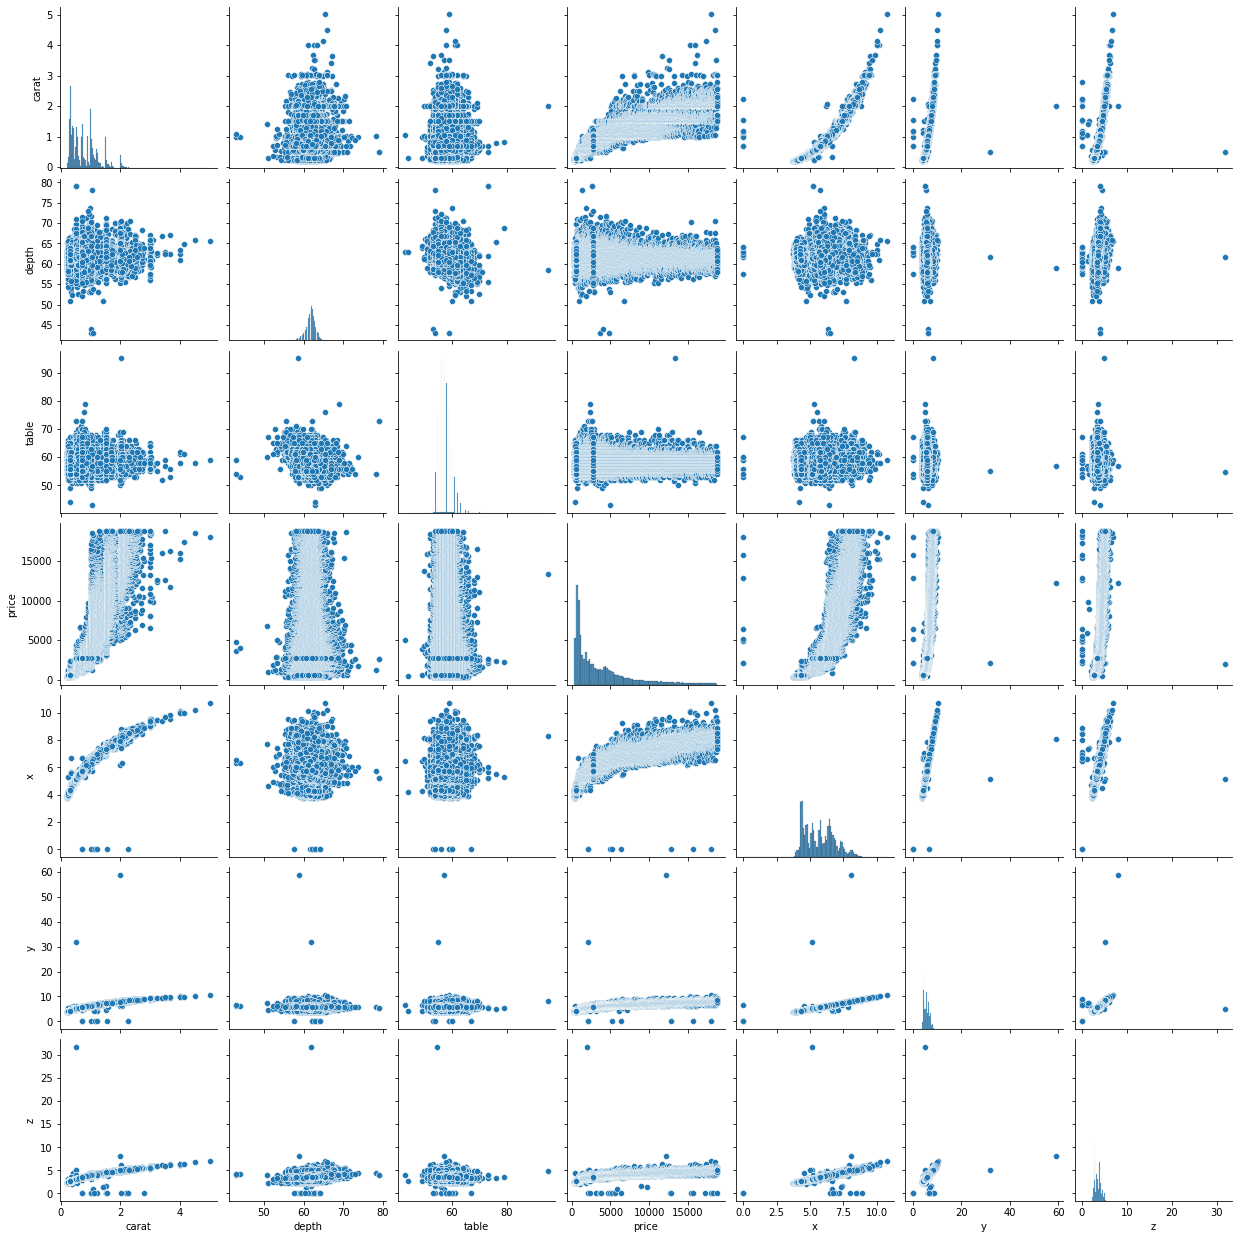

In [35]:
sns.pairplot(df_auto)

In [36]:
df = pd.get_dummies(df, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53820 entries, 0 to 53942
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53820 non-null  float64
 1   depth          53820 non-null  float64
 2   table          53820 non-null  float64
 3   price          53820 non-null  int64  
 4   x              53820 non-null  float64
 5   y              53820 non-null  float64
 6   z              53820 non-null  float64
 7   cut_Good       53820 non-null  uint8  
 8   cut_Ideal      53820 non-null  uint8  
 9   cut_Premium    53820 non-null  uint8  
 10  cut_Very Good  53820 non-null  uint8  
 11  color_E        53820 non-null  uint8  
 12  color_F        53820 non-null  uint8  
 13  color_G        53820 non-null  uint8  
 14  color_H        53820 non-null  uint8  
 15  color_I        53820 non-null  uint8  
 16  color_J        53820 non-null  uint8  
 17  clarity_IF     53820 non-null  uint8  
 18  clarit

In [37]:
df_auto = pd.get_dummies(df, drop_first=True)
df_auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53820 entries, 0 to 53942
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53820 non-null  float64
 1   depth          53820 non-null  float64
 2   table          53820 non-null  float64
 3   price          53820 non-null  int64  
 4   x              53820 non-null  float64
 5   y              53820 non-null  float64
 6   z              53820 non-null  float64
 7   cut_Good       53820 non-null  uint8  
 8   cut_Ideal      53820 non-null  uint8  
 9   cut_Premium    53820 non-null  uint8  
 10  cut_Very Good  53820 non-null  uint8  
 11  color_E        53820 non-null  uint8  
 12  color_F        53820 non-null  uint8  
 13  color_G        53820 non-null  uint8  
 14  color_H        53820 non-null  uint8  
 15  color_I        53820 non-null  uint8  
 16  color_J        53820 non-null  uint8  
 17  clarity_IF     53820 non-null  uint8  
 18  clarit

In [38]:
clf = IsolationForest( max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df_auto)
preds

array([ 1, -1, -1, ...,  1,  1,  1])

In [39]:
df_auto['out'] = preds

In [40]:
df_auto.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,out
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,1,0,0,0,0,0,-1
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,1,0,0,0,-1
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,1,0,0,0,0,0,1,0,0,1
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,1,0,0,1,0,0,0,0,-1


In [41]:
df_auto.out.value_counts()

 1    41007
-1    12813
Name: out, dtype: int64

In [42]:
df_auto = df_auto.loc[df_auto.out == 1]

In [43]:
df_auto.shape

(41007, 25)

Разделим два полученных датасета на выборки

In [44]:
target = df['price']
features = df.drop(['price', 'x', 'y', 'z'],
                        axis = 1)

In [45]:
features_train, features_valid, features_test = np.split(features, [int(.6*len(features)),
                                                                 int(.8*len(features))])
target_train, target_valid, target_test = np.split(target, [int(.6*len(target)),
                                                                 int(.8*len(target))])

In [46]:
target_auto = df_auto['price']
features_auto = df_auto.drop(['price', 'x', 'y', 'z'],
                        axis = 1)

In [47]:
features_train_auto, features_valid_auto, features_test_auto = np.split(features_auto, [int(.6*len(features_auto)),
                                                                 int(.8*len(features_auto))])
target_train_auto, target_valid_auto, target_test_auto = np.split(target_auto, [int(.6*len(target_auto)),
                                                                 int(.8*len(target_auto))])

In [48]:
features_train_auto.shape

(24604, 21)

In [49]:
models = []
columns = ['model', 'data', 'MAE (train)', 'MAE(valid)', 'MAPE(train)', 'MAPE(valid)']
models = pd.DataFrame(data = models, columns = columns)

In [50]:
def models_result(model, name_data): 
    global features_train, features_valid, target_train, target_valid
    global features_train_auto, features_valid_auto, target_train_auto, target_valid_auto
    name_model = str(model)[:-2]
    
    if name_data == 'df_auto':

        model.fit(features_train_auto, target_train_auto)
        result_train= model.predict(features_train_auto)
        result_valid= model.predict(features_valid_auto)
        mae_train = mean_absolute_error(target_train_auto, result_train)
        mae_valid = mean_absolute_error(target_valid_auto, result_valid)
        mape_train = mean_absolute_percentage_error(target_train_auto, result_train)
        mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)

    else:
        
        model.fit(features_train, target_train)
        result_train= model.predict(features_train)
        result_valid= model.predict(features_valid)
        mae_train = mean_absolute_error(target_train, result_train)
        mae_valid = mean_absolute_error(target_valid, result_valid)
        mape_train = mean_absolute_percentage_error(target_train, result_train)
        mape_valid = mean_absolute_percentage_error(target_valid, result_valid)
    
    tmp = [name_model, name_data, mae_train, mae_valid, mape_train, mape_valid]
    models.loc[len(models)]= tmp
    return models

In [51]:
all_models = [LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor(), RandomForestRegressor(), LGBMRegressor(),xgb.XGBRegressor(), CatBoostRegressor()]
all_df = ['df', 'df_auto']

In [52]:
for i in all_models:
    for j in all_df:
        models_result(i, j)
models

Learning rate set to 0.070895
0:	learn: 4117.7714883	total: 62.8ms	remaining: 1m 2s
1:	learn: 3880.6902736	total: 67.2ms	remaining: 33.5s
2:	learn: 3663.7821271	total: 74.3ms	remaining: 24.7s
3:	learn: 3464.9653308	total: 79.7ms	remaining: 19.9s
4:	learn: 3277.9050914	total: 83.6ms	remaining: 16.6s
5:	learn: 3110.6268992	total: 87.3ms	remaining: 14.5s
6:	learn: 2956.1084432	total: 91.2ms	remaining: 12.9s
7:	learn: 2810.7765903	total: 95ms	remaining: 11.8s
8:	learn: 2674.6628543	total: 98.8ms	remaining: 10.9s
9:	learn: 2550.5143232	total: 103ms	remaining: 10.2s
10:	learn: 2441.1557138	total: 106ms	remaining: 9.57s
11:	learn: 2339.1688185	total: 111ms	remaining: 9.1s
12:	learn: 2240.4664502	total: 114ms	remaining: 8.66s
13:	learn: 2153.3008619	total: 118ms	remaining: 8.28s
14:	learn: 2073.0693503	total: 121ms	remaining: 7.97s
15:	learn: 1997.6975034	total: 125ms	remaining: 7.68s
16:	learn: 1931.0731954	total: 129ms	remaining: 7.43s
17:	learn: 1866.6236240	total: 132ms	remaining: 7.21s
18

,model,data,MAE (train),MAE(valid),MAPE(train),MAPE(valid)
0,LinearRegression,df,946.984738,812.725215,0.450416,0.946005
1,LinearRegression,df_auto,619.941741,577.227908,0.350729,0.593360
2,DecisionTreeRegressor,df,16.107779,511.897815,0.006806,0.465453
3,DecisionTreeRegressor,df_auto,19.357015,473.370122,0.013532,0.387650
4,KNeighborsRegressor,df,1077.680144,1303.027202,0.367744,1.414155
5,KNeighborsRegressor,df_auto,651.865762,990.418339,0.292604,0.935181
6,RandomForestRegressor,df,152.443215,478.477356,0.029032,0.436320
7,RandomForestRegressor,df_auto,103.489474,361.405769,0.033530,0.305188
8,LGBMRegressor,df,385.311085,452.021830,0.080157,0.421980
9,LGBMRegressor,df_auto,246.544161,503.815184,0.077112,0.423522


In [53]:
models_sorted = models.sort_values(by='MAPE(valid)')

In [54]:
models_sorted

,model,data,MAE (train),MAE(valid),MAPE(train),MAPE(valid)
13,<catboost.core.CatBoostRegressor object at 0x7...,df_auto,236.070661,225.572615,0.072241,0.198976
12,<catboost.core.CatBoostRegressor object at 0x7...,df,370.158750,238.301520,0.078863,0.236727
7,RandomForestRegressor,df_auto,103.489474,361.405769,0.033530,0.305188
11,"XGBRegressor(base_score=0.5, booster='gbtree',...",df_auto,222.048785,426.473800,0.067702,0.351331
3,DecisionTreeRegressor,df_auto,19.357015,473.370122,0.013532,0.387650
10,"XGBRegressor(base_score=None, booster=None, ca...",df,346.083809,426.409858,0.070668,0.391854
8,LGBMRegressor,df,385.311085,452.021830,0.080157,0.421980
9,LGBMRegressor,df_auto,246.544161,503.815184,0.077112,0.423522
6,RandomForestRegressor,df,152.443215,478.477356,0.029032,0.436320
2,DecisionTreeRegressor,df,16.107779,511.897815,0.006806,0.465453


In [55]:
X = features_train_auto.copy()

In [56]:
features_train_auto.columns

Index(['carat', 'depth', 'table', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'out'],
      dtype='object')

In [57]:
features_train_auto.shape

(24604, 21)

## Отбор признаков



### Удаление признаков с низкой дисперсией

In [58]:
selector = VarianceThreshold(threshold=0.05)
X_disp = selector.fit_transform(X)
X_disp.shape

(24604, 17)

In [59]:
X_disp_valid = selector.transform(features_valid_auto)

In [60]:
selector.get_feature_names_out()

array(['carat', 'depth', 'table', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H',
       'color_I', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS2'], dtype=object)

### Выбор признаков с использованием критерия хи-квадрат

In [61]:
chi = SelectKBest(chi2, k=17).fit(features_train_auto, target_train_auto)

In [62]:
X_chi = chi.transform(features_train_auto)
features_train_auto.shape

(24604, 21)

In [ ]:
X_valid_chi = features_valid_auto.copy()
X_valid_chi = chi.transform(X_valid_chi)

Проверим эффективность отбора признаков, для этого построим модель на полученных тренировочных выборках.

In [64]:
final_model = CatBoostRegressor(metric_period=200)


In [65]:
final_model.fit(X_disp, target_train_auto); 
result_train= final_model.predict(X_disp) 
result_valid= final_model.predict(X_disp_valid) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

Learning rate set to 0.067914
0:	learn: 2644.8695245	total: 4.89ms	remaining: 4.89s
200:	learn: 763.0540301	total: 703ms	remaining: 2.8s
400:	learn: 726.0052459	total: 1.31s	remaining: 1.96s
600:	learn: 701.4989390	total: 1.92s	remaining: 1.27s
800:	learn: 683.8649204	total: 2.51s	remaining: 625ms
999:	learn: 670.3690421	total: 3.1s	remaining: 0us
MAE train: 339.6771612198943
MAE valid: 317.7043150533318
MAPE train: 0.09788250363416612
MAPE train: 0.2756890308657453


In [66]:
final_model.fit(X_chi, target_train_auto); 
result_train= final_model.predict(X_chi) 
result_valid= final_model.predict(X_valid_chi) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

Learning rate set to 0.067914
0:	learn: 2791.6224106	total: 3.38ms	remaining: 3.38s
200:	learn: 2673.9148394	total: 520ms	remaining: 2.06s
400:	learn: 2666.1092789	total: 1.04s	remaining: 1.56s
600:	learn: 2664.0363691	total: 1.56s	remaining: 1.04s
800:	learn: 2663.1662667	total: 2.1s	remaining: 521ms
999:	learn: 2662.6747169	total: 2.61s	remaining: 0us
MAE train: 2067.380321298475
MAE valid: 2562.2150485226834
MAPE train: 1.5446514371414921
MAPE train: 2.575985050986106


Полученные метрики показали более низкое качество моделей.Значит в процессе выбора признаков были отвергнуты в том числе и информативные признаки.

In [67]:
final_model.fit(features_train_auto, target_train_auto); 
result_train= final_model.predict(features_train_auto) 
result_valid= final_model.predict(features_valid_auto) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

Learning rate set to 0.067914
0:	learn: 2644.7984308	total: 3.54ms	remaining: 3.54s
200:	learn: 504.3038657	total: 621ms	remaining: 2.47s
400:	learn: 434.4219222	total: 1.23s	remaining: 1.83s
600:	learn: 406.8196728	total: 1.83s	remaining: 1.21s
800:	learn: 390.5585693	total: 2.43s	remaining: 605ms
999:	learn: 379.1211241	total: 3.05s	remaining: 0us
MAE train: 236.07066050023326
MAE valid: 225.57261500709768
MAPE train: 0.07224084994893072
MAPE train: 0.19897598375840134


Выясним какие признаки оказались наиболее информативными для данной модели.

Feature importances:
 1. feature 'carat' (56.8055)
 2. feature 'clarity_SI2' (7.9563)
 3. feature 'clarity_SI1' (4.3567)
 4. feature 'clarity_VVS2' (4.3523)
 5. feature 'clarity_VS2' (3.6797)
 6. feature 'color_J' (3.3607)
 7. feature 'color_I' (3.2741)
 8. feature 'clarity_VS1' (3.0777)
 9. feature 'color_H' (2.6698)
10. feature 'clarity_VVS1' (2.6418)
11. feature 'clarity_IF' (2.4104)
12. feature 'color_G' (1.9772)
13. feature 'depth' (1.2360)
14. feature 'cut_Ideal' (0.9007)
15. feature 'color_F' (0.5251)
16. feature 'table' (0.4625)
17. feature 'color_E' (0.1931)
18. feature 'cut_Very Good' (0.0581)
19. feature 'cut_Premium' (0.0500)
20. feature 'cut_Good' (0.0127)
21. feature 'out  ' (0.0000)


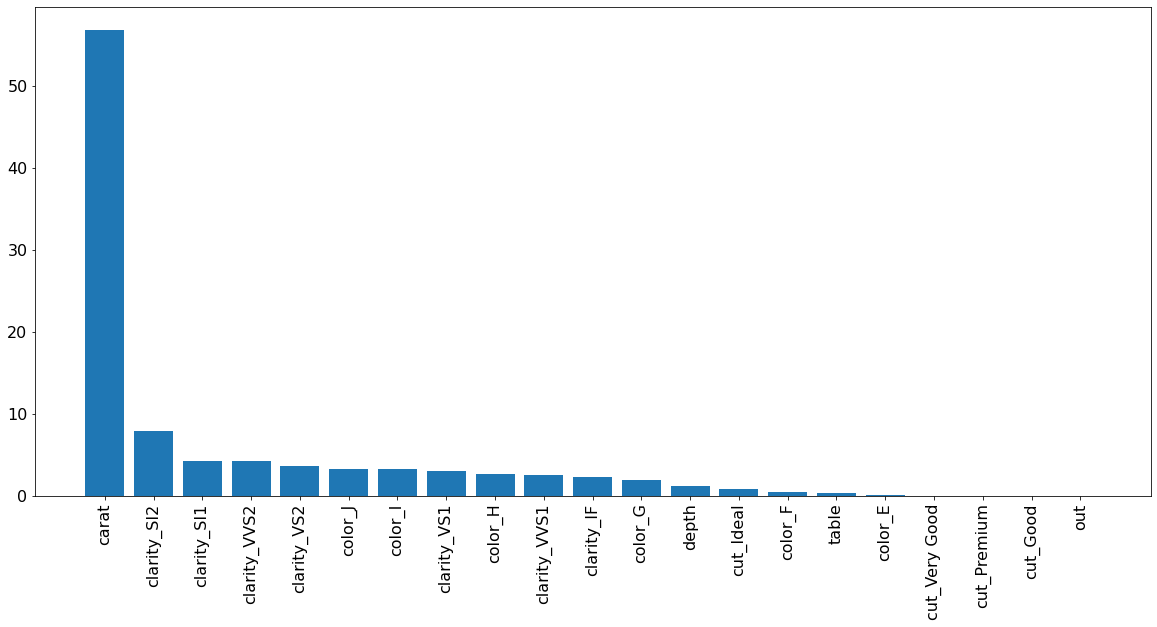

In [68]:
feature_import = final_model.feature_importances_
col_names = features_train_auto.columns
indices = np.argsort(feature_import)[::-1]
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, col_names[idx], feature_import[idx]))
d1 = pd.Series(data =feature_import, index =col_names  ).sort_values(ascending=False)
plt.figure(figsize=(20,9))
plt.bar(d1.index,d1.values)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=90);

In [69]:
feature_importances = d1.iloc[:7].index
feature_importances

Index(['carat', 'clarity_SI2', 'clarity_SI1', 'clarity_VVS2', 'clarity_VS2',
       'color_J', 'color_I'],
      dtype='object')

In [70]:
X_train = features_train_auto[feature_importances]
X_valid = features_valid_auto[feature_importances]

In [71]:
final_model.fit(X_train, target_train_auto); 
result_train= final_model.predict(X_train) 
result_valid= final_model.predict(X_valid) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

Learning rate set to 0.067914
0:	learn: 2639.9545168	total: 3.71ms	remaining: 3.71s
200:	learn: 820.2676872	total: 542ms	remaining: 2.15s
400:	learn: 812.7149212	total: 1.08s	remaining: 1.62s
600:	learn: 809.5201343	total: 1.62s	remaining: 1.07s
800:	learn: 806.6933107	total: 2.15s	remaining: 535ms
999:	learn: 804.7159142	total: 2.69s	remaining: 0us
MAE train: 419.50389596345525
MAE valid: 470.1753499664363
MAPE train: 0.11007192494701737
MAPE train: 0.3916544615587483


Поскольку использование только наиболее информативных признаков не привело к улучшению качества модели, то для построения финальной модели будем использовать все имеющиеся признаки. Перейдем к выбору гиперпараметров модели.

### Выбор гиперпараметров модели

In [72]:
final_model = GridSearchCV(CatBoostRegressor(metric_period=200),{
                            'max_depth': range(6,25, 5),
                             'n_estimators' : range(30, 100, 20)
                             },
                             cv = 5,
                             
                              n_jobs=-1)

In [73]:
final_model.fit(features_train_auto, target_train_auto)
result_train= final_model.predict(features_train_auto) 
result_valid= final_model.predict(features_valid_auto) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

Learning rate set to 0.5
0:	learn: 1905.7276753	total: 53.9ms	remaining: 1.56s
29:	learn: 492.6046607	total: 200ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1687.1521584	total: 14.2ms	remaining: 411ms
29:	learn: 561.6146309	total: 599ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1133.1295794	total: 14.1ms	remaining: 689ms
49:	learn: 325.9478010	total: 757ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1133.1295794	total: 9.84ms	remaining: 679ms
69:	learn: 312.5299669	total: 770ms	remaining: 0us
Learning rate set to 0.464351
0:	learn: 1930.8909331	total: 12.8ms	remaining: 1.14s
89:	learn: 412.2474531	total: 1.51s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1857.3100080	total: 127ms	remaining: 3.68s
29:	learn: 394.5302399	total: 1.67s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1615.7575313	total: 29.8ms	remaining: 865ms
29:	learn: 432.2955126	total: 1.71s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1115.7980639	total: 64.9ms	remaining: 3.18s
49:	lea

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Learning rate set to 0.5
0:	learn: 1133.1295794	total: 60.7ms	remaining: 1.76s
29:	learn: 347.7372145	total: 465ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1797.1316035	total: 12.8ms	remaining: 626ms
49:	learn: 423.2614765	total: 682ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1905.7276753	total: 42.6ms	remaining: 2.94s
69:	learn: 429.8464490	total: 1.27s	remaining: 0us
Learning rate set to 0.464351
0:	learn: 1979.4431500	total: 10.6ms	remaining: 948ms
89:	learn: 423.7518492	total: 1.44s	remaining: 0us
Learning rate set to 0.464355
0:	learn: 1744.7421170	total: 5.61ms	remaining: 500ms
89:	learn: 457.3426486	total: 956ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1115.7980639	total: 55.8ms	remaining: 1.62s
29:	learn: 303.5987387	total: 1.74s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1717.8976823	total: 37.6ms	remaining: 1.84s
49:	learn: 312.0268448	total: 3.46s	remaining: 0us
Learning rate set to 0.5
0:	learn: 1835.1318144	total: 75.7ms	remaining: 5.22s
6

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 5593, in fit
    save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/opt/conda/lib/python3.7/site-packages/catboost/core.py", line 2270, in _fit
    callbacks=callbacks
  File "/opt/conda/lib/pytho

Learning rate set to 0.481016
0:	learn: 1780.8814722	total: 8.06ms	remaining: 718ms
89:	learn: 407.9777589	total: 304ms	remaining: 0us
MAE train: 253.23829987259657
MAE valid: 228.493256108539
MAPE train: 0.07753423440072958
MAPE train: 0.20397413139979376


In [74]:
result_test= final_model.predict(features_test) 
mae_test = mean_absolute_error(target_test, result_test) 
mape_test = mean_absolute_percentage_error(target_test, result_test)
print('MAE test:', mae_test)

print('MAPE test:', mape_test)

MAE test: 324.9238630529343
MAPE test: 0.17504222648107837


Построим нейронную сеть для датасета:

In [75]:
%time
regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes = [150, 50]).fit(features_train_auto, target_train_auto)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs


In [76]:
result_train= regr.predict(features_train_auto) 
result_valid= regr.predict(features_valid_auto) 
mae_train = mean_absolute_error(target_train_auto, result_train) 
mae_valid = mean_absolute_error(target_valid_auto, result_valid) 
mape_train = mean_absolute_percentage_error(target_train_auto, result_train) 
mape_valid = mean_absolute_percentage_error(target_valid_auto, result_valid)
print('MAE train:', mae_train)
print('MAE valid:', mae_valid)
print('MAPE train:', mape_train)
print('MAPE train:', mape_valid)

result_test= regr.predict(features_test_auto) 
mae_test = mean_absolute_error(target_test_auto, result_test) 
mape_test = mean_absolute_percentage_error(target_test_auto, result_test)
print('MAE test:', mae_test)

print('MAPE test:', mape_test)

MAE train: 297.43036634041886
MAE valid: 145.05906553604174
MAPE train: 0.08495401105611913
MAPE train: 0.1341146897800696
MAE test: 190.12882776730322
MAPE test: 0.09617891449593811


В ходе работы была выполнена предобработка данных и построена модель с помощью алгоритма CatBoost, значение MAPE на тестовой выборке составило - 0,175.
Также на основе имеющихся данных была обучена нейронная сеть, получено значение MAPE на тестовой выборке - 0,096.